<a href="https://colab.research.google.com/github/sensharma/adlproject/blob/main/adlproj_base_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x #selects tf 1.x in Google Colab; Deeplift needs tf1
from google.colab import drive
drive.mount('/content/gdrive')
# !ls /content/gdrive/MyDrive/data
# !ls /content/gdrive/MyDrive/colabdrive/adlproject/saved_models/

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x #selects tf 1.x in Google Colab; Deeplift needs tf1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install deeplift shap > /dev/null

In [ ]:
import os
import time
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras import backend as K

import torch
from torch import nn

import shap
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import get_integrated_gradients_function, compile_func


models_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'saved_models')
plots_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'plots', 'MNIST')
model_file = f"{models_path}/keras2_mnist_cnn_allconv.h5"
pt_model_file = f"{models_path}/mnist_checkpoint"

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

keras_model = keras.models.load_model(model_file)
keras_model.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_______________________________________

No training configuration found in save file: the model was *not* compiled. Compile it manually.


**Conv2D layers:**
- 32 filters: f = (16, 16); s = 1; p=0; (valid)
- 64 filters: f = (9, 9); s = 1; p=0; (valid)

In [ ]:
class Net(nn.Module):
    def __init__(self, h=28, w=28, n_channels=1):
        super(Net, self).__init__()
        self.h = h
        self.w = w
        self.n_channels = n_channels

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(16, 16), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1)),
            nn.ReLU(),
            nn.Dropout(0.25),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def x_compat(self, x):
        # print(f"x - type {type(x)}")
        if type(x) is not torch.Tensor:
            x_tensor = torch.from_numpy(x)
        else:
            x_tensor = x
        x_out = x_tensor.clone().reshape(x.shape[0],
                                         self.n_channels,
                                         self.h,
                                         self.w)
        return x_out.float()

    def forward(self, x):
        if x.ndim != 4:
            # print("in compat")
            x = self.x_compat(x)
        x = self.conv_layers(x)
        # print(f"shape: {x.shape}")
        # x = x.view(-1, 1600)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [ ]:
checkpoint = torch.load(pt_model_file, map_location=device)
pt_model = Net()
pt_model.load_state_dict(checkpoint['model_state_dict'])
pt_model.to(device)
pt_model.eval()

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(16, 16), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [ ]:
def keras_mnist_loader(indices=[5846]):
    if type(indices) is list:
        data_idxs = np.array(indices)
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    rX_test = X_test[indices, :, :, None]
    ry_test = y_test[indices]
    X_test = X_test / 255
    rX_test = rX_test / 255
    return X_train, y_train, X_test, y_test, rX_test, ry_test

def gen_random_data_subset(n=60, len_test_set=10000):
    test_indices = np.arange(len_test_set)
    rand_indices = np.random.choice(
        test_indices, size=n, replace=False)

    # loading the random selection of test items from keras
    X_train, y_train, X_test, y_test, rX_test, ry_test = keras_mnist_loader(rand_indices)
    return X_train, y_train, X_test, y_test, rX_test, ry_test

def gen_random_label_subset(label, n=60, len_test_set=10000):
    test_indices = np.arange(len_test_set)
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_test = X_test / 255
    label_indices = np.where(y_test==label)
    rand_indices = np.random.choice(
        label_indices[0], size=n, replace=False)
    X_test_sample = X_test[rand_indices, :, :, None]
    y_test_sample = y_test[rand_indices]
    # loading the random selection of test items from keras
    return X_test_sample, y_test_sample

In [ ]:
# indices to visualise
indices = [5846, 61]
X_train, y_train, X_test, y_test, rX_test, ry_test = keras_mnist_loader(indices)

In [ ]:
# grad_model required for integrated_gradient
grad_model = kc.convert_model_from_saved_files(
    h5_file=model_file, nonlinear_mxts_mode=NonlinearMxtsMode.Gradient
)

gradient_func = grad_model.get_target_multipliers_func(
    find_scores_layer_idx=0, target_layer_idx=-2
)

# the New DeepLIFT model (better aligned with Shapeley values)
revealcancel_model = kc.convert_model_from_saved_files(
    h5_file=model_file, nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel
)

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func(
    [deeplift_model.get_layers()[0].get_activation_vars()],
    deeplift_model.get_layers()[-1].get_activation_vars(),
)

revealcancel_func = revealcancel_model.get_target_contribs_func(
    find_scores_layer_idx=0, target_layer_idx=-2
)

integrated_grads_10 = get_integrated_gradients_function(gradient_func, 10)

# kernel shap -> 0s as background
ker_shap_background = np.zeros((1, 784))

# kernel shap predict function
def f(z):
    return keras_model.predict(z.reshape(z.shape[0], 28, 28, 1))

# deep shap can average over background or be given a fixed (say 0) background
# deep_shap_background = torch.from_numpy(np.expand_dims(X_train[:500], axis=1))
# deep_shap_background = deep_shap_background/255

deep_shap_background = torch.zeros_like(torch.from_numpy(np.expand_dims(X_train[0:1], axis=1))).float()

deep_exp = shap.DeepExplainer(pt_model, deep_shap_background.to(device))

ker_exp = shap.KernelExplainer(f, ker_shap_background)

SCORING_METHODS = [
    ("revealcancel", "DL_RC", revealcancel_func),
    ("integrated_grads_10", "IG_10", integrated_grads_10),
    ("deep_shap", "d_shap", None),
    ("kernel_shap", "k_shap", None),
]

nonlinear_mxts_mode is set to: Gradient



The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case



nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case




In [ ]:
def calculate_scores(rX_test, ry_test, k_shap_nsamples=5000):
    method_scores = dict.fromkeys(['scores', 'labels'])
    method_scores['scores'] = {}

    for method_name, _, score_func in SCORING_METHODS:
        if method_name in ["revealcancel", "integrated_grads_10"]:
            print(f"Computing scores for: {method_name}")
            
            method_scores['scores'][method_name] = []
            init_time = time.time()
            for task_idx in range(10):
                
                scores = np.array(
                    score_func(
                        task_idx=task_idx,
                        input_data_list=[rX_test],  # [X_test],
                        input_references_list=[np.zeros_like(rX_test)],
                        batch_size=1,  # 1000,
                        progress_update=None))  # None
                method_scores['scores'][method_name].append(scores)
            print(f"Time taken for {method_name}: {time.time() - init_time:.3f}s")

    method_scores['labels'] = ry_test

    print("\n \n Computing scores for DeepSHAP:")
    method_name = "deep_shap"
    rX_test_ds = torch.from_numpy(np.swapaxes(np.swapaxes(rX_test, 1, -1), -1, -2)).float()
    init_time = time.time()
    d_shap_values = deep_exp.shap_values(rX_test_ds)
    d_shap_values = [np.swapaxes(np.swapaxes(d, 1, -1), 1, 2)
                    for d in d_shap_values]

    keys = np.arange(len(d_shap_values))
    keys = [key for key in keys]
    ds_dict = dict.fromkeys(keys)
    for key in keys:
        ds_dict[key] = d_shap_values[int(key)]
    method_scores['scores'][method_name] = ds_dict
    print(f"Time taken for {method_name}: {time.time() - init_time:.3f}s")

    print("\n \n Computing scores for: KernelSHAP:")
    method_name = 'kernel_shap'
    init_time = time.time()
    rX_test_ker = rX_test.copy()
    rX_test_ker = rX_test_ker.squeeze().reshape(rX_test_ker.shape[0], -1)
    k_shap_values = ker_exp.shap_values(
        rX_test_ker, nsamples=k_shap_nsamples)  # runs model nsamples no. of times, paper = 50000 

    k_shap_values = [ks.reshape(scores.shape[0],
                                int(ks.shape[1]**0.5),
                                int(ks.shape[1]**0.5),
                                1) for ks in k_shap_values]

    method_scores['scores'][method_name] = k_shap_values
    print(f"Time taken for {method_name}: {time.time() - init_time:.3f}s")
    return method_scores

In [ ]:
def viz_scores(scores, ax):
    reshaped_scores = scores.reshape(28, 28)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores < center) * \
        reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > center)*reshaped_scores/float(the_max)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])


def get_masked_image(idx, scores, task_1, task_2, n_to_erase):
    difference = scores[(task_1)][idx].ravel() - \
        scores[(task_2)][idx].ravel()
    
    """Note: UP TO n_to_erase, as long as diff > 0"""
    top_nth_threshold = max(
        sorted(difference, key=lambda x: -x)[n_to_erase], 0.0)
    thresholded_points = 1.0 * (difference <= top_nth_threshold)
    masked_inp = thresholded_points.reshape(
        28, 28, 1) * rX_test[idx]  # X_test
    return masked_inp


# Digit conversion plot
def plot_mask_figures(idx, task_1, task_2, method_names, n_to_erase, save=False):
    print("example index: " + str(idx))
    print(
        "Columns:",
        "Original Digit;",
        "Digit " + str(task_1) + " scores;",
        "Digit " + str(task_2) + " scores;",
        str(task_1) + "->" + str(task_2) + " masking scores;",
    )

    print("Order of the methods is: " + ", ".join(str(x)
                                                  for x in method_names))
    for method_name in method_names:
        scores = method_scores['scores'][method_name]
        mean_scores_over_all_tasks = np.mean(
            np.array([scores[i][idx] for i in range(10)]), axis=0
        )
        f, axarr = plt.subplots(1, 4, sharey=False, figsize=(5, 3))
        viz_scores(rX_test[idx], axarr[0])  # orig: X_test
        viz_scores(scores[task_1][idx] -
                   mean_scores_over_all_tasks, axarr[1])
        viz_scores(scores[task_2][idx] -
                   mean_scores_over_all_tasks, axarr[2])
        viz_scores(get_masked_image(
            idx, scores, task_1, task_2, n_to_erase), axarr[3])
    if save:
        plt.savefig(f'{plots_path}/digit{task_1}to{task_2}.png')
    plt.show()

In [ ]:
indices = [5846, 61, 77, 81, 99]
X_train, y_train, X_test, y_test, rX_test, ry_test = keras_mnist_loader(indices)
method_scores = calculate_scores(rX_test, ry_test, k_shap_nsamples=50000)

Computing scores for: revealcancel
Time taken for revealcancel: 2.502s
Computing scores for: integrated_grads_10
Time taken for integrated_grads_10: 3.662s

 
 Computing scores for DeepSHAP:
Time taken for deep_shap: 0.182s

 
 Computing scores for: KernelSHAP:



Time taken for kernel_shap: 55.884s


example index: 0
Columns: Original Digit; Digit 8 scores; Digit 3 scores; 8->3 masking scores;
Order of the methods is: revealcancel, integrated_grads_10, deep_shap, kernel_shap


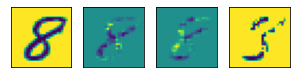

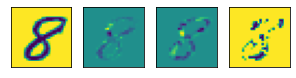

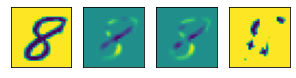

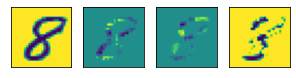

example index: 1
Columns: Original Digit; Digit 8 scores; Digit 3 scores; 8->3 masking scores;
Order of the methods is: revealcancel, integrated_grads_10, deep_shap, kernel_shap


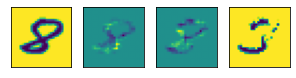

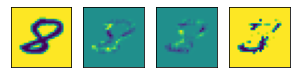

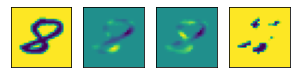

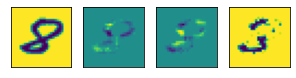

example index: 2
Columns: Original Digit; Digit 2 scores; Digit 5 scores; 2->5 masking scores;
Order of the methods is: revealcancel, integrated_grads_10, deep_shap, kernel_shap


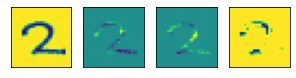

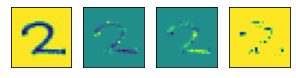

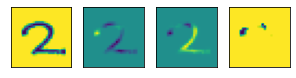

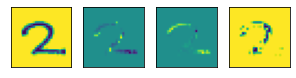

example index: 3
Columns: Original Digit; Digit 6 scores; Digit 8 scores; 6->8 masking scores;
Order of the methods is: revealcancel, integrated_grads_10, deep_shap, kernel_shap


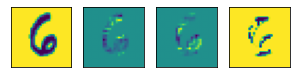

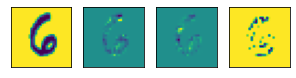

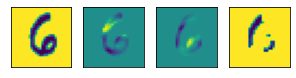

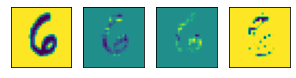

example index: 4
Columns: Original Digit; Digit 9 scores; Digit 4 scores; 9->4 masking scores;
Order of the methods is: revealcancel, integrated_grads_10, deep_shap, kernel_shap


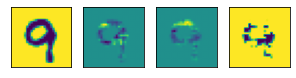

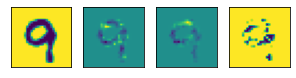

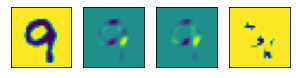

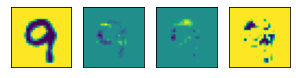

In [ ]:
method_names = ["revealcancel", "integrated_grads_10", "deep_shap", "kernel_shap"]
# method_names = ["revealcancel", "integrated_grads_10", "kernel_shap"]

# Not so good 8->3; 8->6 example
# plot_two_way_figures(61,8,3,6,method_names,n_to_erase)

# Good 8->3; 8->6 example
# plot_two_way_figures(5846,8,3,6,method_names,n_to_erase)

# Bad 3->8; 3->9 example; doesn't work very well when switching from the
# minority class to the majority class
# (in terms of proximity to 0s and 1s)
shift_map = {
    0: 8,
    1: 7,
    2: 5,
    3: 1,
    4: 1,
    5: 6,
    6: 8,
    7: 1,
    8: 3,
    9: 4,
}

n_to_erase = 157  # approx 20% [of 784 (28 x 28)] = 157
for idx, label in enumerate(ry_test):
    plot_mask_figures(idx, label, shift_map[label],
                      method_names, n_to_erase, save=True)   # orig index 5846

In [ ]:
def compute_delta_log_odds(X, y, method_name, predict_func, imp_scores,
                           original_class, target_class,
                           num_perturbations):
    ''''original class mask is the numpy mask (True/False) for original class, obtained from the labels'''
    # original_class_mask = ry_test == original_class
    original_class_mask = y==original_class

    '''selects training data based on the mask -> np.compress'''
    X = np.compress(condition=original_class_mask, a=X, axis=0)
    X_pt = np.swapaxes(np.swapaxes(X, 1, -1), 2, -1)
    X_pt = torch.from_numpy(X_pt).float().to(device)

    """predictions: using the original test image"""
    # compute log-odds of model for those two classes (predict function is "pre_softmax", i.e., outputs before feeding to softmax)
    ''' What if I change the predict function to a function that return the same from pytorch?'''

    if method_name in ['revealcancel', 'integrated_grads_10']:
        predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                                     input_data_list=[
                                                                         X],
                                                                     batch_size=X.shape[0], progress_update=None))   # orig batch_size = 200
        orig_log_odds = predictions[:, original_class] - \
            predictions[:, target_class]
    elif method_name == 'deep_shap':
        with torch.no_grad():
            predictions = pt_model(X_pt).cpu().detach().numpy()
        orig_log_odds = np.log(
            predictions[:, original_class] / predictions[:, target_class])
    elif method_name == 'kernel_shap':
        predictions = keras_model.predict(X)
        orig_log_odds = np.log(
            predictions[:, original_class] / predictions[:, target_class])

    # make num_perturbations to move from original_class
    # to target_class according to imp_scores
    # first, get the difference of imp_scores for the two classes

    diff_of_scores = (np.compress(original_class_mask, imp_scores[original_class].reshape((-1, 784)), axis=0) -
                      np.compress(original_class_mask, imp_scores[target_class].reshape((-1, 784)), axis=0))
    modified_inp = []

    """This is the masking -> 0-mask for MNIST"""
    """modified_inp -> list of masked images"""

    for inp, diff_of_scores in zip(X, diff_of_scores):
        top_nth_threshold = max(
            sorted(diff_of_scores, key=lambda x: -x)[num_perturbations], 0.0)
        thresholded_points = 1.0*(diff_of_scores <= top_nth_threshold)
        modified_inp.append(thresholded_points.reshape(28, 28, 1)*inp)
    modified_inp = np.array(modified_inp)

    if method_name == 'deep_shap':
        modified_inp = np.swapaxes(np.swapaxes(modified_inp, 1, -1), 2, -1)
        modified_inp = torch.from_numpy(modified_inp).float().to(device)

    """new_predictions: for the masked images, using trained classifier"""
    # assess change in log-odds for the modified images
    if method_name in ['revealcancel', 'integrated_grads_10']:
        new_predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                                         input_data_list=[
                                                                             modified_inp],
                                                                         batch_size=X.shape[0], progress_update=None))   # orig batch_size = 200
        new_log_odds = new_predictions[:, original_class] - \
            new_predictions[:, target_class]

    elif method_name == 'deep_shap':
        with torch.no_grad():
            new_predictions = pt_model(modified_inp).cpu().detach().numpy()
        new_log_odds = np.log(
            new_predictions[:, original_class] / new_predictions[:, target_class])
        
    elif method_name == 'kernel_shap':
        new_predictions = keras_model.predict(modified_inp)
        new_log_odds = np.log(
            new_predictions[:, original_class] / new_predictions[:, target_class])

    to_return = orig_log_odds - new_log_odds
    return (to_return,
            sum(new_log_odds < 0.0)/float(len(new_log_odds)),
            new_predictions[:, [original_class, target_class]],
            predictions[:, [original_class, target_class]])

In [ ]:
pre_softmax_func_inner = K.function([keras_model.input, K.learning_phase()],
                                    [keras_model.layers[-2].output])


def pre_softmax_func(x): return pre_softmax_func_inner(x+[False])[0]


def barplot_scores(original_class, target_class, X_inp, y_inp, scoring_methods, scores, n_to_erase, ks_niter, save=False):
    method_names = [x[0] for x in scoring_methods]
    short_names = [x[1] for x in scoring_methods]
    scores_to_plot = []
    fig, ax = plt.subplots(figsize=(2*len(method_names), 5))
    """
    logodds obtained here by calling compute_delta_log_odds.
    - what is predict_func=pre_softmax_fuc ? -> linear layer prior to softmax
    """
    for method_name in method_names:
        logodds_diff, flipped, new_predictions, old_predictions = compute_delta_log_odds(
            X=X_inp, y=y_inp,
            method_name=method_name,
            predict_func=pre_softmax_func,
            imp_scores=scores['scores'][method_name],
            original_class=original_class,
            target_class=target_class,
            num_perturbations=n_to_erase)
        
        scores_to_plot.append(logodds_diff)
    ax.boxplot(scores_to_plot, widths=[
               0.5 for x in method_names], showmeans=True, meanline=True)
    # ax.set_ylim(-1000,17000)
    ax.set_ylabel("Change in log-odds")
    ax.set_xticklabels(short_names)
    plt.title(str(original_class)+" --> "+str(target_class), fontsize=24)
    plt.tick_params(labelsize=17)
    if save:
        plt.savefig(f'{plots_path}/log_odds{len(SCORING_METHODS)}_{original_class}to{target_class}_{len(y_inp)}samp_ks_{int(ks_niter/1000)}k.png')
    plt.show()

In [ ]:
def subsample_barplot_scores(orig, tgt, scoring_methods, n_sample=30, ks_niter=5000, n_to_erase=157, save=False):
    X_sample, y_sample = gen_random_label_subset(orig, n=n_sample)
    method_scores = calculate_scores(X_sample, y_sample, k_shap_nsamples=ks_niter) # k_shap_nsamples = 50k in paper
    barplot_scores(orig, tgt, X_sample, y_sample, SCORING_METHODS, method_scores, n_to_erase, ks_niter=ks_niter, save=save)

Computing scores for: revealcancel
Time taken for revealcancel: 25.314s
Computing scores for: integrated_grads_10
Time taken for integrated_grads_10: 34.985s

 
 Computing scores for DeepSHAP:
Time taken for deep_shap: 2.594s

 
 Computing scores for: KernelSHAP:



Time taken for kernel_shap: 570.023s


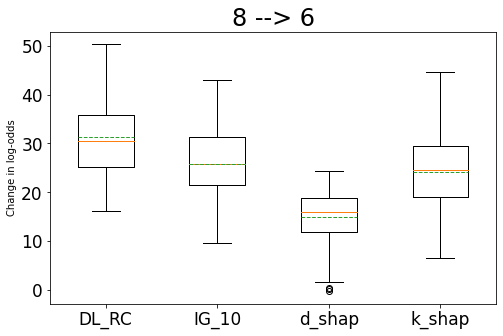

In [ ]:
subsample_barplot_scores(8, 6, SCORING_METHODS, n_sample=50, ks_niter=50000, save=True)

Erasing

Computing scores for: revealcancel
Time taken for revealcancel: 26.456s
Computing scores for: integrated_grads_10
Time taken for integrated_grads_10: 37.073s

 
 Computing scores for DeepSHAP:
Time taken for deep_shap: 2.613s

 
 Computing scores for: KernelSHAP:



Time taken for kernel_shap: 583.290s


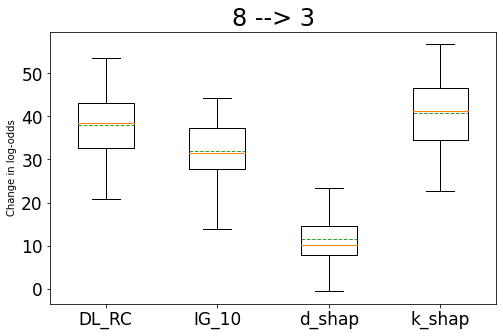

In [ ]:
subsample_barplot_scores(8, 3, SCORING_METHODS, n_sample=50, ks_niter=50000, save=True)

Computing scores for: revealcancel
Time taken for revealcancel: 6.454s
Computing scores for: integrated_grads_10
Time taken for integrated_grads_10: 18.707s

 
 Computing scores for DeepSHAP:
Time taken for deep_shap: 1.717s

 
 Computing scores for: KernelSHAP:



Time taken for kernel_shap: 588.575s


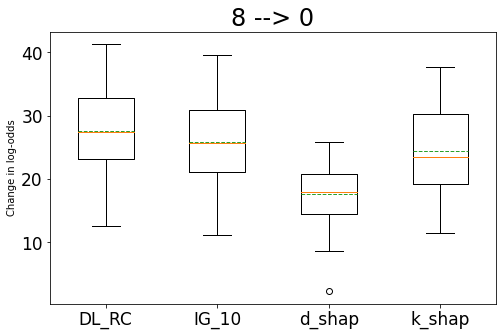

In [ ]:
subsample_barplot_scores(8, 0, SCORING_METHODS, n_sample=50, ks_niter=50000, save=True)

Generating

Computing scores for: revealcancel
Time taken for revealcancel: 27.071s
Computing scores for: integrated_grads_10
Time taken for integrated_grads_10: 37.180s

 
 Computing scores for DeepSHAP:
Time taken for deep_shap: 2.742s

 
 Computing scores for: KernelSHAP:



Time taken for kernel_shap: 545.372s


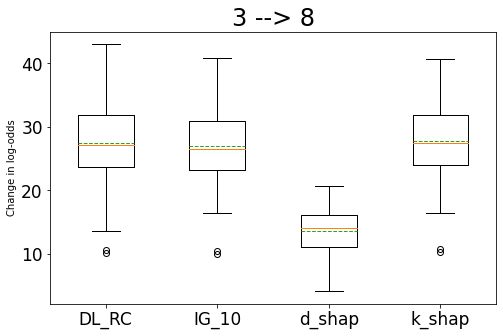

In [ ]:
subsample_barplot_scores(3, 8, SCORING_METHODS, n_sample=50, ks_niter=50000, save=True)